# Imports

In [82]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison, extract_eval_metrics, plot_metrics_with_error
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)


In [83]:
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)


add_engineered_features(train_df, spo2_to_po2)
add_engineered_features(test_df, spo2_to_po2)
add_engineered_features(val_df, spo2_to_po2)

features = ['shift_raw', 'SpO2_over_PiO2',  'SpO2_squared', 'log_PiO2']


In [84]:
# train_df = train_df[train_df['SpO2(%)'] < 95]
# test_df = test_df[test_df['SpO2(%)'] < 95]
# val_df = val_df[val_df['SpO2(%)'] < 95]


# A) Full Multi-Point Feature Model


🔁 Running model for n = 1

🔁 Running model for n = 2

🔁 Running model for n = 3

🔁 Running model for n = 4

🔁 Running model for n = 5

==== Full Multi-Point Feature Model (Test Set) ====

   n_points     MAE     MSE    RMSE    Bias    MAPE   nRMSE  MAE_std  MSE_std  \
0         1  0.9004  1.7744  0.9899  0.1216  8.5655  5.2634   0.7534   4.8556   
1         2  0.6876  0.8351  0.7382 -0.0796  6.6337  3.9252   0.5035   1.4358   
2         3  0.5445  0.5296  0.5858  0.0293  5.4298  3.1148   0.4363   0.8602   
3         4  0.5124  0.6424  0.5528  0.2255  5.1086  2.9394   0.5562   1.5170   
4         5  0.4416  0.4404  0.4738  0.0739  4.4267  2.5191   0.4344   0.8176   

   RMSE_std  N_patients  
0    0.8981          66  
1    0.5428          66  
2    0.4350          66  
3    0.5849          65  
4    0.4683          65  

==== Full Multi-Point Feature Model (Validation Set) ====

   n_points     MAE     MSE    RMSE    Bias     MAPE   nRMSE  MAE_std  \
0         1  1.0979  3.3750  1.2542

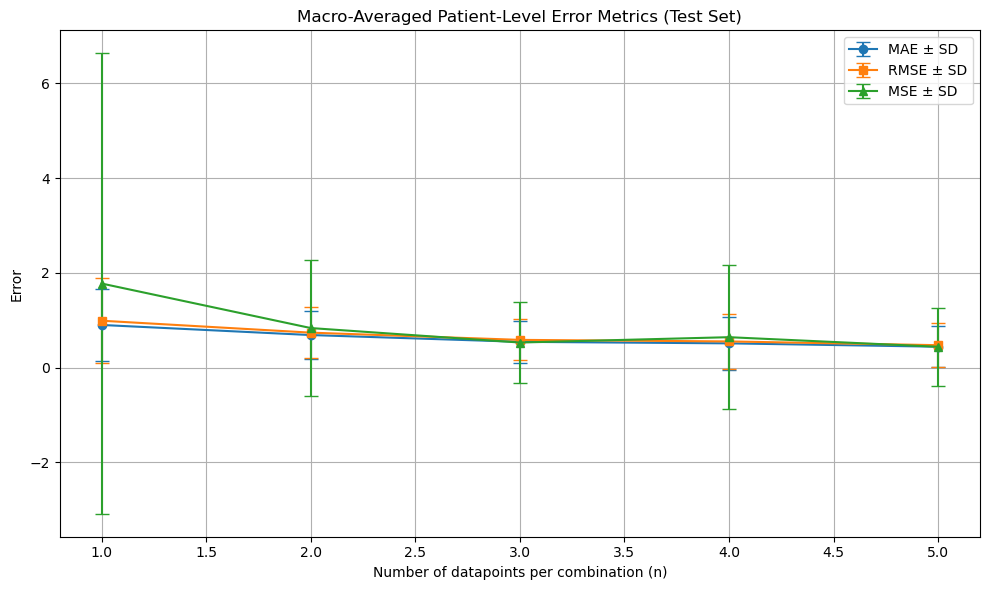

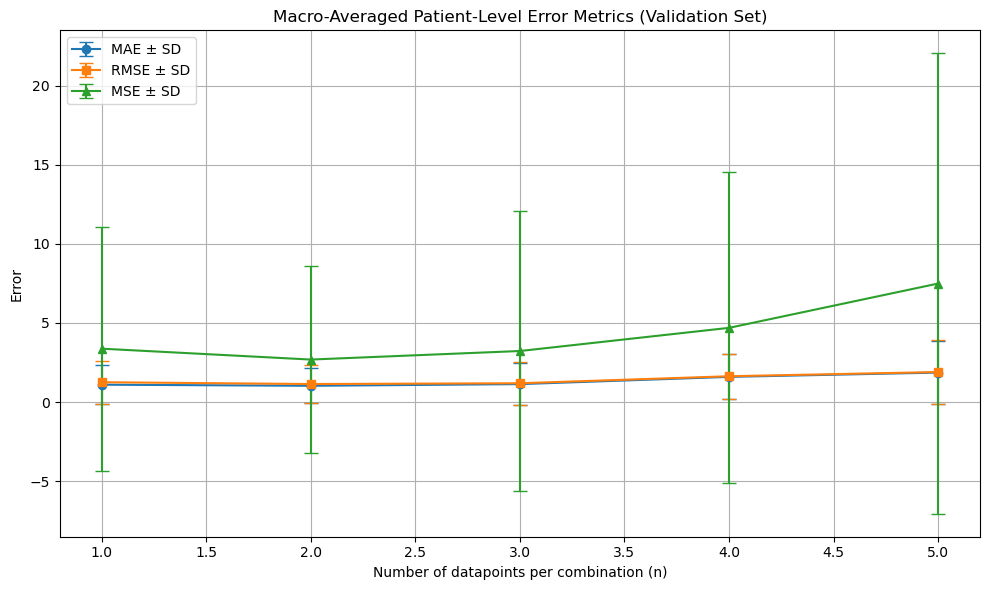

In [85]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression
import random
import matplotlib.pyplot as plt

from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, extract_eval_metrics, plot_metrics_with_error
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json

# ------------------------------------------
# Function to build full multi-point features
# ------------------------------------------
def make_full_multi_point_features(df, spo2_to_po2, n=3, max_combos=2, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Anon.Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        combos = list(combinations(range(len(group)), n))
        combos = rng.sample(combos, max_combos) if len(combos) > max_combos else combos

        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)
            row = {'Anon.Patient_ID': pid}

            for i in range(n):
                row[f'SpO2_over_PiO2_{i+1}'] = points.loc[i, 'SpO2_over_PiO2']
                row[f'SpO2_squared_{i+1}']   = points.loc[i, 'SpO2_squared']
                row[f'log_PiO2_{i+1}']       = points.loc[i, 'log_PiO2']

            pcs = spo2_to_po2(points['SpO2(%)'].values)
            row['joint_shift_raw'] = np.mean(points['PiO2(kPa)'].values - pcs)
            row['shift'] = points['shift'].mean()
            records.append(row)

    return pd.DataFrame(records)

# ------------------------------------------
# Setup
# ------------------------------------------
max_n = 5
max_combos = 2
seed = 42
results_test = []
results_val = []


# ------------------------------------------
# Model training and evaluation loop
# ------------------------------------------
for n in range(1, max_n + 1):
    print(f"\n🔁 Running model for n = {n}")

    train_features = make_full_multi_point_features(train_df, spo2_to_po2, n=n, max_combos=max_combos, seed=seed)
    test_features = make_full_multi_point_features(test_df, spo2_to_po2, n=n, max_combos=max_combos, seed=seed)
    val_features = make_full_multi_point_features(val_df, spo2_to_po2, n=n, max_combos=max_combos, seed=seed)

    if train_features.empty or test_features.empty or val_features.empty:
        print(f"⚠️  Not enough data for n = {n}, skipping.")
        continue

    # Dynamic feature list: 4 per point + joint summary
    feat_cols = []
    for i in range(n):
        feat_cols.extend([
            f'SpO2_over_PiO2_{i+1}',
            f'SpO2_squared_{i+1}',
            f'log_PiO2_{i+1}',
        ])
    feat_cols.append('joint_shift_raw')

    # Train model
    model = LinearRegression().fit(train_features[feat_cols], train_features['shift'])

    # Predict
    test_features['y_pred'] = model.predict(test_features[feat_cols])
    val_features['y_pred'] = model.predict(val_features[feat_cols])

    # Evaluate
    test_summary = evaluate_macro_patient_level(test_features, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')
    val_summary = evaluate_macro_patient_level(val_features, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')

    # Log
    results_test.append({'n_points': n, **extract_eval_metrics(test_summary)})
    results_val.append({'n_points': n, **extract_eval_metrics(val_summary)})

# ------------------------------------------
# Show results
# ------------------------------------------
results_test_df = pd.DataFrame(results_test)
results_val_df = pd.DataFrame(results_val)

print("\n==== Full Multi-Point Feature Model (Test Set) ====\n")
print(results_test_df)

print("\n==== Full Multi-Point Feature Model (Validation Set) ====\n")
print(results_val_df)

plot_metrics_with_error(results_test_df, "Macro-Averaged Patient-Level Error Metrics (Test Set)")
plot_metrics_with_error(results_val_df,  "Macro-Averaged Patient-Level Error Metrics (Validation Set)")


In [86]:
results_full = results_test_df.copy()
results_full_val = results_val_df.copy()

# B) multi-point raw shift model 


🔁 Averaged Feature Model for n = 1

🔁 Averaged Feature Model for n = 2

🔁 Averaged Feature Model for n = 3

🔁 Averaged Feature Model for n = 4

🔁 Averaged Feature Model for n = 5

==== Averaged Engineered Features Model (Test Set) ====

   n_points     MAE     MSE    RMSE    Bias    MAPE   nRMSE  MAE_std  MSE_std  \
0         1  0.9004  1.7744  0.9899  0.1216  8.5655  5.2634   0.7534   4.8556   
1         2  0.8085  1.2972  0.8667 -0.0888  7.7024  4.6080   0.6986   3.5014   
2         3  0.8541  1.9613  0.9065  0.0735  7.8675  4.8199   1.0760   8.9563   
3         4  0.8353  1.9706  0.8784  0.1150  7.7547  4.6707   1.0903   8.4946   
4         5  0.8026  1.7799  0.8313  0.0637  7.4515  4.4201   0.9845   7.1976   

   RMSE_std  N_patients  
0    0.8981          66  
1    0.7446          66  
2    1.0757          66  
3    1.1035          65  
4    1.0516          65  

==== Averaged Engineered Features Model (Validation Set) ====

   n_points     MAE     MSE    RMSE    Bias     MAPE   

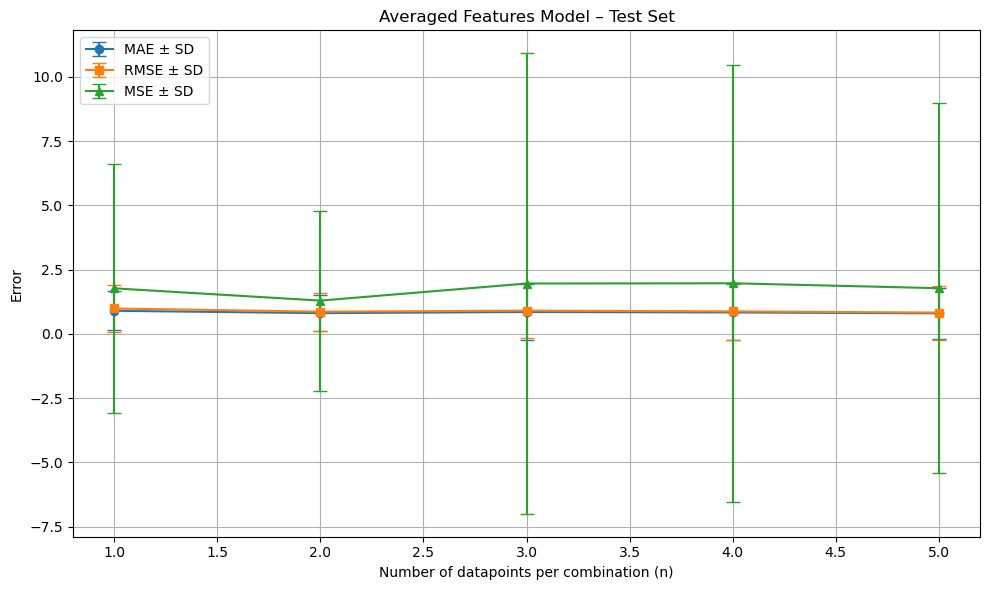

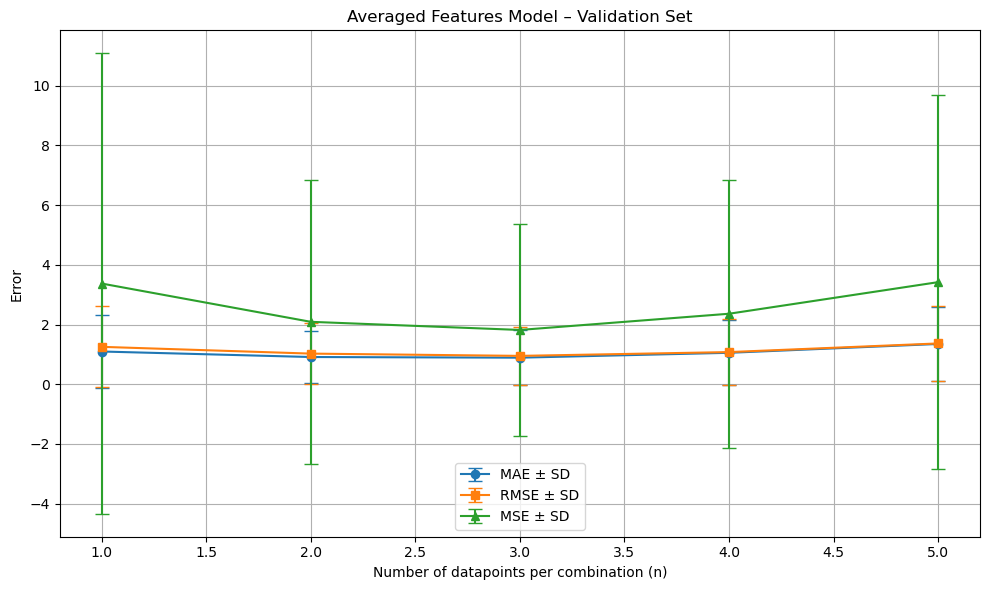

In [87]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# Loading the datasets and odc again

train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

add_engineered_features(train_df, spo2_to_po2)
add_engineered_features(test_df, spo2_to_po2)
add_engineered_features(val_df, spo2_to_po2)


def make_raw_shift_features(df, spo2_to_po2, n=3, max_combos=2, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Anon.Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        combos = list(combinations(range(len(group)), n))
        combos = rng.sample(combos, max_combos) if len(combos) > max_combos else combos

        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)

            # Compute joint shift_raw
            pcs = spo2_to_po2(points['SpO2(%)'].values)
            joint_shift_raw = np.mean(points['PiO2(kPa)'].values - pcs)

            # Get row with lowest SpO2
            min_idx = points['SpO2(%)'].idxmin()
            min_row = df.loc[min_idx]

            record = {
                'Anon.Patient_ID': pid,
                'joint_shift_raw': joint_shift_raw,
                'log_PiO2': min_row['log_PiO2'],
                'SpO2_squared': min_row['SpO2_squared'],
                'SpO2_over_PiO2': min_row['SpO2_over_PiO2'],
                'shift': points['shift'].mean()
            }

            records.append(record)
    return pd.DataFrame(records)

def make_averaged_features(df, spo2_to_po2, n=3, max_combos=2, seed=42):
    records = []
    rng = random.Random(seed)
    for pid, group in df.groupby('Anon.Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        combos = list(combinations(range(len(group)), n))
        combos = rng.sample(combos, max_combos) if len(combos) > max_combos else combos

        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)

            pcs = spo2_to_po2(points['SpO2(%)'].values)
            joint_shift_raw = np.mean(points['PiO2(kPa)'].values - pcs)

            record = {
                'Anon.Patient_ID': pid,
                'mean_log_PiO2': points['log_PiO2'].mean(),
                'mean_SpO2_squared': points['SpO2_squared'].mean(),
                'mean_SpO2_over_PiO2': points['SpO2_over_PiO2'].mean(),
                'joint_shift_raw': joint_shift_raw,
                'shift': points['shift'].mean()
            }

            records.append(record)
    return pd.DataFrame(records)


from sklearn.linear_model import LinearRegression

results_avg = []
results_avg_val = []

for n in range(1, 6):
    print(f"\n🔁 Averaged Feature Model for n = {n}")
    train_feat = make_averaged_features(train_df, spo2_to_po2, n=n, max_combos=2, seed=42)
    test_feat  = make_averaged_features(test_df,  spo2_to_po2, n=n, max_combos=2, seed=42)
    val_feat   = make_averaged_features(val_df,   spo2_to_po2, n=n, max_combos=2, seed=42)

    if train_feat.empty or test_feat.empty or val_feat.empty:
        print(f"⚠️ Skipping n = {n} due to insufficient data")
        continue

    feat_cols = ['joint_shift_raw', 'mean_log_PiO2', 'mean_SpO2_squared', 'mean_SpO2_over_PiO2']

    model = LinearRegression().fit(train_feat[feat_cols], train_feat['shift'])

    test_feat['y_pred'] = model.predict(test_feat[feat_cols])
    val_feat['y_pred']  = model.predict(val_feat[feat_cols])

    test_summary = evaluate_macro_patient_level(test_feat, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')
    val_summary  = evaluate_macro_patient_level(val_feat,  y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')

    results_avg.append({'n_points': n, **extract_eval_metrics(test_summary)})
    results_avg_val.append({'n_points': n, **extract_eval_metrics(val_summary)})


results_avg_df = pd.DataFrame(results_avg)
results_avg_val_df = pd.DataFrame(results_avg_val)

print("\n==== Averaged Engineered Features Model (Test Set) ====\n")
print(results_avg_df)

print("\n==== Averaged Engineered Features Model (Validation Set) ====\n")
print(results_avg_val_df)

plot_metrics_with_error(results_avg_df, "Averaged Features Model – Test Set")
plot_metrics_with_error(results_avg_val_df, "Averaged Features Model – Validation Set")


In [88]:
results_raw = results_avg.copy()
results_raw_val = results_avg_val.copy()

# C) Single-Point Model

In [89]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.interpolate import PchipInterpolator
import random

# Loading the datasets and odc again

train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

add_engineered_features(train_df, spo2_to_po2)
add_engineered_features(test_df, spo2_to_po2)
add_engineered_features(val_df, spo2_to_po2)

,Anon.Patient_ID,PiO2(kPa),SpO2(%),Hb,shift,shunt,log_PiO2,log_SpO2,SpO2_over_PiO2,SpO2_squared,Hb_SpO2,saturation_deficit,CaO2_estimate,shift_raw
0,1,23.7,94.1,10.0,14.90,8.6,3.165475,4.544358,3.970464,8854.81,941.00,5.9,12.682870,16.644228
1,1,20.7,83.2,10.0,14.90,8.6,3.030134,4.421247,4.019324,6922.24,832.00,16.8,11.212970,16.124513
2,1,31.3,99.4,10.0,14.90,8.6,3.443618,4.599152,3.175719,9880.36,994.00,0.6,13.416630,14.492400
3,1,34.1,97.3,10.0,14.90,8.6,3.529297,4.577799,2.853372,9467.29,973.00,2.7,13.143910,24.550644
4,2,23.9,97.6,11.1,10.60,5.3,3.173878,4.580877,4.083682,9525.76,1083.36,2.4,14.591114,13.923116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,65,16.2,91.5,8.8,9.33,0.0,2.785011,4.516339,5.648148,8372.25,805.20,8.5,10.839900,10.099524
295,65,15.6,87.4,8.8,9.33,0.0,2.747271,4.470495,5.602564,7638.76,769.12,12.6,10.354568,10.415575
296,66,35.8,91.1,8.0,26.70,6.5,3.577948,4.511958,2.544693,8299.21,728.80,8.9,9.876900,29.812191
297,66,32.9,90.7,8.0,26.70,6.5,3.493473,4.507557,2.756839,8226.49,725.60,9.3,9.825030,27.018365


In [90]:
from itertools import combinations
from sklearn.linear_model import LinearRegression

def predict_average_single_point(df, model, features, n=3, max_combos=2, seed=42):
    """Generate averaged predictions using single-point model."""
    records = []
    rng = random.Random(seed)

    for pid, group in df.groupby('Anon.Patient_ID'):
        group = group.reset_index(drop=True)
        if len(group) < n:
            continue
        combos = list(combinations(range(len(group)), n))
        combos = rng.sample(combos, max_combos) if len(combos) > max_combos else combos

        for idx_tuple in combos:
            points = group.loc[list(idx_tuple)].reset_index(drop=True)
            X = points[features].values
            y_pred_points = model.predict(X)
            y_true_avg = points["shift"].mean()

            records.append({
                "Anon.Patient_ID": pid,
                "y_pred": np.mean(y_pred_points),
                "shift": y_true_avg
            })

    return pd.DataFrame(records)


In [91]:
# Features used per single measurement
single_point_features = ['shift_raw', 'SpO2_over_PiO2', 'SpO2_squared', 'log_PiO2']

# Train the base single-point model
base_model = LinearRegression().fit(train_df[single_point_features], train_df['shift'])

results_avg_pred = []
results_avg_pred_val = []

for n in range(1, 6):
    print(f"\n🔁 Averaged Single-Point Prediction Model for n = {n}")

    test_combos = predict_average_single_point(test_df, base_model, single_point_features, n=n, max_combos=2, seed=42)
    val_combos  = predict_average_single_point(val_df,  base_model, single_point_features, n=n, max_combos=2, seed=42)

    if test_combos.empty or val_combos.empty:
        print(f"⚠️ Skipping n = {n} due to insufficient data")
        continue

    # Evaluate using patient-level macro metrics
    test_summary = evaluate_macro_patient_level(test_combos, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')
    val_summary  = evaluate_macro_patient_level(val_combos,  y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')

    results_avg_pred.append({'n_points': n, **extract_eval_metrics(test_summary)})
    results_avg_pred_val.append({'n_points': n, **extract_eval_metrics(val_summary)})



🔁 Averaged Single-Point Prediction Model for n = 1

🔁 Averaged Single-Point Prediction Model for n = 2


/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names


🔁 Averaged Single-Point Prediction Model for n = 3

🔁 Averaged Single-Point Prediction Model for n = 4


/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/MasterThesis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names


🔁 Averaged Single-Point Prediction Model for n = 5



==== Averaged Single-Point Prediction Model (Test Set) ====

   n_points     MAE     MSE    RMSE    Bias    MAPE   nRMSE  MAE_std  MSE_std  \
0         1  0.8890  1.6559  0.9815 -0.0024  8.4369  5.2185   0.6982   4.1113   
1         2  0.7716  1.2605  0.8236 -0.0102  7.4023  4.3791   0.7228   3.4456   
2         3  0.8117  1.6238  0.8499  0.0580  7.6479  4.5189   0.9579   6.4420   
3         4  0.7716  1.5104  0.8070  0.0903  7.3720  4.2908   0.9282   5.5056   
4         5  0.7422  1.3397  0.7720  0.0317  7.2422  4.1046   0.8153   4.4588   

   RMSE_std  N_patients  
0    0.8386          66  
1    0.7688          66  
2    0.9568          66  
3    0.9341          65  
4    0.8691          65  

==== Averaged Single-Point Prediction Model (Validation Set) ====

   n_points     MAE     MSE    RMSE    Bias    MAPE   nRMSE  MAE_std  MSE_std  \
0         1  1.0685  2.9631  1.2142  0.2783  8.4829  6.2268   1.1282   6.6147   
1         2  0.9133  2.1546  1.0221  0.2214  7.3292  5.2416   0.9

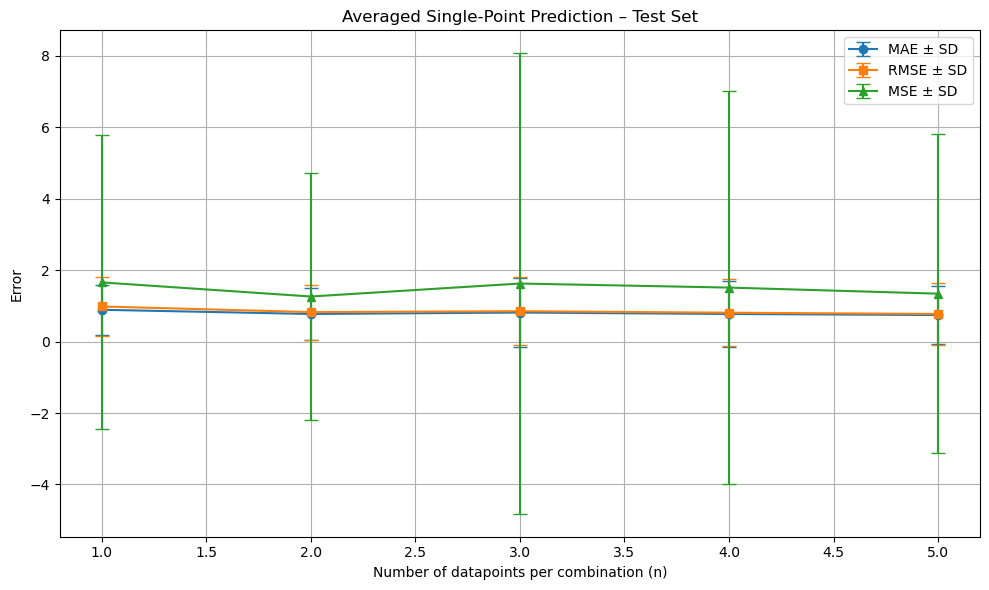

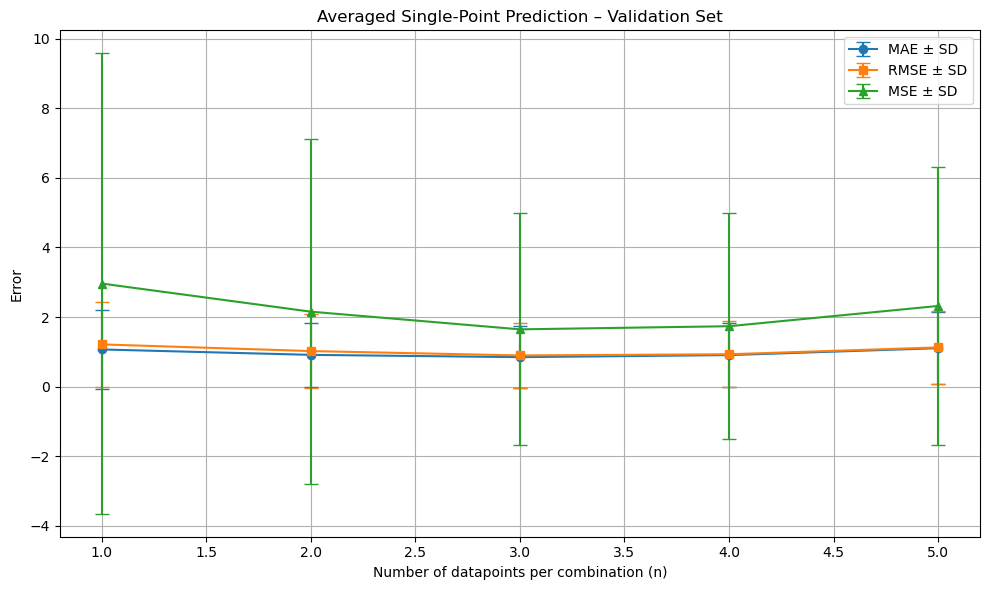

In [92]:
results_avg_pred_df = pd.DataFrame(results_avg_pred)
results_avg_pred_val_df = pd.DataFrame(results_avg_pred_val)

print("\n==== Averaged Single-Point Prediction Model (Test Set) ====\n")
print(results_avg_pred_df)

print("\n==== Averaged Single-Point Prediction Model (Validation Set) ====\n")
print(results_avg_pred_val_df)

plot_metrics_with_error(results_avg_pred_df, "Averaged Single-Point Prediction – Test Set")
plot_metrics_with_error(results_avg_pred_val_df, "Averaged Single-Point Prediction – Validation Set")


In [93]:
results_single = results_avg_pred_df.copy()
results_single_val = results_avg_pred_val_df.copy()

# Plot

# Comparison of Modeling Strategies

In [94]:
results_full_df   = pd.DataFrame(results_full)
results_raw_df    = pd.DataFrame(results_raw)
results_single_df = pd.DataFrame(results_single)


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Create comparison DataFrames for test set
comparison_test = pd.DataFrame({
    'n_points': results_full_df['n_points'],
    'Full_MAE': results_full_df['MAE'],
    'Full_MAE_std': results_full_df['MAE_std'],
    'Full_MSE': results_full_df['MSE'],
    'Full_MSE_std': results_full_df['MSE_std'],
    'Full_RMSE': results_full_df['RMSE'],
    'Full_RMSE_std': results_full_df['RMSE_std'],
    'Full_Bias': results_full_df['Bias'],
    'Raw_MAE': results_raw_df['MAE'],
    'Raw_MAE_std': results_raw_df['MAE_std'],
    'Raw_MSE': results_raw_df['MSE'],
    'Raw_MSE_std': results_raw_df['MSE_std'],
    'Raw_RMSE': results_raw_df['RMSE'],
    'Raw_RMSE_std': results_raw_df['RMSE_std'],
    'Raw_Bias': results_raw_df['Bias'],
    'Single_MAE': results_single_df['MAE'],
    'Single_MAE_std': results_single_df['MAE_std'],
    'Single_MSE': results_single_df['MSE'],
    'Single_MSE_std': results_single_df['MSE_std'],
    'Single_RMSE': results_single_df['RMSE'],
    'Single_RMSE_std': results_single_df['RMSE_std'],
    'Single_Bias': results_single_df['Bias']
})

# Save raw metrics to CSV
comparison_test.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_raw_metrics.csv', index=False)

# Create a formatted table with all metrics
def format_metric_with_std(value, std):
    return f"{value:.3f} ± {std:.3f}"

comparison_table = pd.DataFrame()
for n in comparison_test['n_points'].unique():
    row = comparison_test[comparison_test['n_points'] == n].iloc[0]
    comparison_table.loc[f"n={int(n)}", "Full Feature (MAE)"] = format_metric_with_std(row['Full_MAE'], row['Full_MAE_std'])
    comparison_table.loc[f"n={int(n)}", "Full Feature (MSE)"] = format_metric_with_std(row['Full_MSE'], row['Full_MSE_std'])
    comparison_table.loc[f"n={int(n)}", "Full Feature (RMSE)"] = format_metric_with_std(row['Full_RMSE'], row['Full_RMSE_std'])
    comparison_table.loc[f"n={int(n)}", "Full Feature (Bias)"] = f"{row['Full_Bias']:.3f}"
    
    comparison_table.loc[f"n={int(n)}", "Raw Shift (MAE)"] = format_metric_with_std(row['Raw_MAE'], row['Raw_MAE_std'])
    comparison_table.loc[f"n={int(n)}", "Raw Shift (MSE)"] = format_metric_with_std(row['Raw_MSE'], row['Raw_MSE_std'])
    comparison_table.loc[f"n={int(n)}", "Raw Shift (RMSE)"] = format_metric_with_std(row['Raw_RMSE'], row['Raw_RMSE_std'])
    comparison_table.loc[f"n={int(n)}", "Raw Shift (Bias)"] = f"{row['Raw_Bias']:.3f}"
    
    comparison_table.loc[f"n={int(n)}", "Single Point (MAE)"] = format_metric_with_std(row['Single_MAE'], row['Single_MAE_std'])
    comparison_table.loc[f"n={int(n)}", "Single Point (MSE)"] = format_metric_with_std(row['Single_MSE'], row['Single_MSE_std'])
    comparison_table.loc[f"n={int(n)}", "Single Point (RMSE)"] = format_metric_with_std(row['Single_RMSE'], row['Single_RMSE_std'])
    comparison_table.loc[f"n={int(n)}", "Single Point (Bias)"] = f"{row['Single_Bias']:.3f}"

print("Comparison of Model Strategies (Test Set)")
print("Format: mean ± std")
print("\nMetrics Table:")
print(comparison_table)

# Save the formatted table to CSV
comparison_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_table.csv')

Comparison of Model Strategies (Test Set)
Format: mean ± std

Metrics Table:
    Full Feature (MAE) Full Feature (MSE) Full Feature (RMSE)  \
n=1      0.900 ± 0.753      1.774 ± 4.856       0.990 ± 0.898   
n=2      0.688 ± 0.503      0.835 ± 1.436       0.738 ± 0.543   
n=3      0.544 ± 0.436      0.530 ± 0.860       0.586 ± 0.435   
n=4      0.512 ± 0.556      0.642 ± 1.517       0.553 ± 0.585   
n=5      0.442 ± 0.434      0.440 ± 0.818       0.474 ± 0.468   

    Full Feature (Bias) Raw Shift (MAE) Raw Shift (MSE) Raw Shift (RMSE)  \
n=1               0.122   0.900 ± 0.753   1.774 ± 4.856    0.990 ± 0.898   
n=2              -0.080   0.808 ± 0.699   1.297 ± 3.501    0.867 ± 0.745   
n=3               0.029   0.854 ± 1.076   1.961 ± 8.956    0.906 ± 1.076   
n=4               0.226   0.835 ± 1.090   1.971 ± 8.495    0.878 ± 1.103   
n=5               0.074   0.803 ± 0.985   1.780 ± 7.198    0.831 ± 1.052   

    Raw Shift (Bias) Single Point (MAE) Single Point (MSE)  \
n=1          

In [96]:
# Function to build a comparison table for a single metric
def build_metric_table(metric: str, std_suffix="_std"):
    metric_table = pd.DataFrame()
    for n in comparison_test['n_points'].unique():
        row = comparison_test[comparison_test['n_points'] == n].iloc[0]
        label = f"n = {int(n)}"
        metric_table.loc[label, "Full Feature"] = format_metric_with_std(row[f"Full_{metric}"], row[f"Full_{metric}{std_suffix}"])
        metric_table.loc[label, "Raw Shift"]    = format_metric_with_std(row[f"Raw_{metric}"], row[f"Raw_{metric}{std_suffix}"])
        metric_table.loc[label, "Single Point"] = format_metric_with_std(row[f"Single_{metric}"], row[f"Single_{metric}{std_suffix}"])
    return metric_table

# Create one table per metric
mae_table  = build_metric_table("MAE")
mse_table  = build_metric_table("MSE")
rmse_table = build_metric_table("RMSE")
bias_table = pd.DataFrame()
for n in comparison_test['n_points'].unique():
    row = comparison_test[comparison_test['n_points'] == n].iloc[0]
    label = f"n = {int(n)}"
    bias_table.loc[label, "Full Feature"] = f"{row['Full_Bias']:.3f}"
    bias_table.loc[label, "Raw Shift"]    = f"{row['Raw_Bias']:.3f}"
    bias_table.loc[label, "Single Point"] = f"{row['Single_Bias']:.3f}"

# Display tables
print("\nMAE Comparison:")
print(mae_table)

print("\nRMSE Comparison:")
print(rmse_table)

print("\nMSE Comparison:")
print(mse_table)

print("\nBias Comparison:")
print(bias_table)

# Save to CSVs for use in thesis
# Save formatted metric tables
mae_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_mae.csv')
mse_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_mse.csv')
rmse_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_rmse.csv')
bias_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_bias.csv')



MAE Comparison:
        Full Feature      Raw Shift   Single Point
n = 1  0.900 ± 0.753  0.900 ± 0.753  0.889 ± 0.698
n = 2  0.688 ± 0.503  0.808 ± 0.699  0.772 ± 0.723
n = 3  0.544 ± 0.436  0.854 ± 1.076  0.812 ± 0.958
n = 4  0.512 ± 0.556  0.835 ± 1.090  0.772 ± 0.928
n = 5  0.442 ± 0.434  0.803 ± 0.985  0.742 ± 0.815

RMSE Comparison:
        Full Feature      Raw Shift   Single Point
n = 1  0.990 ± 0.898  0.990 ± 0.898  0.982 ± 0.839
n = 2  0.738 ± 0.543  0.867 ± 0.745  0.824 ± 0.769
n = 3  0.586 ± 0.435  0.906 ± 1.076  0.850 ± 0.957
n = 4  0.553 ± 0.585  0.878 ± 1.103  0.807 ± 0.934
n = 5  0.474 ± 0.468  0.831 ± 1.052  0.772 ± 0.869

MSE Comparison:
        Full Feature      Raw Shift   Single Point
n = 1  1.774 ± 4.856  1.774 ± 4.856  1.656 ± 4.111
n = 2  0.835 ± 1.436  1.297 ± 3.501  1.260 ± 3.446
n = 3  0.530 ± 0.860  1.961 ± 8.956  1.624 ± 6.442
n = 4  0.642 ± 1.517  1.971 ± 8.495  1.510 ± 5.506
n = 5  0.440 ± 0.818  1.780 ± 7.198  1.340 ± 4.459

Bias Comparison:
      Full F

In [97]:
results_raw_val = pd.DataFrame(results_raw_val)
results_full_val = pd.DataFrame(results_full_val)
results_single_val = pd.DataFrame(results_single_val)


In [98]:
def build_metric_table_dual(metric: str, std_suffix="_std"):
    metric_table = pd.DataFrame()

    for n in comparison_test['n_points'].unique():
        # Test data
        row_test = comparison_test[comparison_test['n_points'] == n].iloc[0]
        # Validation data (assumes same ordering and n_points)
        row_val_full   = results_full_val[results_full_val['n_points'] == n].iloc[0]
        row_val_raw    = results_raw_val[results_raw_val['n_points'] == n].iloc[0]
        row_val_single = results_single_val[results_single_val['n_points'] == n].iloc[0]

        label = f"n = {int(n)}"
        # Test metrics
        metric_table.loc[label, "Full (Test)"]   = format_metric_with_std(row_test[f"Full_{metric}"], row_test[f"Full_{metric}{std_suffix}"])
        metric_table.loc[label, "Raw (Test)"]    = format_metric_with_std(row_test[f"Raw_{metric}"], row_test[f"Raw_{metric}{std_suffix}"])
        metric_table.loc[label, "Single (Test)"] = format_metric_with_std(row_test[f"Single_{metric}"], row_test[f"Single_{metric}{std_suffix}"])
        # Val metrics
        metric_table.loc[label, "Full (Val)"]   = format_metric_with_std(row_val_full[metric], row_val_full[f"{metric}{std_suffix}"])
        metric_table.loc[label, "Raw (Val)"]    = format_metric_with_std(row_val_raw[metric], row_val_raw[f"{metric}{std_suffix}"])
        metric_table.loc[label, "Single (Val)"] = format_metric_with_std(row_val_single[metric], row_val_single[f"{metric}{std_suffix}"])

    return metric_table

# Build
mae_table  = build_metric_table_dual("MAE")
mse_table  = build_metric_table_dual("MSE")
rmse_table = build_metric_table_dual("RMSE")

# Bias: manual (no std)
bias_table = pd.DataFrame()
for n in comparison_test['n_points'].unique():
    row_test = comparison_test[comparison_test['n_points'] == n].iloc[0]
    row_val_full   = results_full_val[results_full_val['n_points'] == n].iloc[0]
    row_val_raw    = results_raw_val[results_raw_val['n_points'] == n].iloc[0]
    row_val_single = results_single_val[results_single_val['n_points'] == n].iloc[0]

    label = f"n = {int(n)}"
    bias_table.loc[label, "Full (Test)"]   = f"{row_test['Full_Bias']:.3f}"
    bias_table.loc[label, "Raw (Test)"]    = f"{row_test['Raw_Bias']:.3f}"
    bias_table.loc[label, "Single (Test)"] = f"{row_test['Single_Bias']:.3f}"
    bias_table.loc[label, "Full (Val)"]    = f"{row_val_full['Bias']:.3f}"
    bias_table.loc[label, "Raw (Val)"]     = f"{row_val_raw['Bias']:.3f}"
    bias_table.loc[label, "Single (Val)"]  = f"{row_val_single['Bias']:.3f}"


output_dir = Path(PROJECT_ROOT) / 'results' / 'multipoint'
output_dir.mkdir(parents=True, exist_ok=True)

mae_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_mae.csv')
mse_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_mse.csv')
rmse_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_rmse.csv')
bias_table.to_csv(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_bias.csv')


In [99]:
# Create line plots for each metric
metrics = ['MAE', 'MSE', 'RMSE', 'Bias']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Plot lines with error bars for each model
    ax.errorbar(comparison_test['n_points'], 
               comparison_test[f'Full_{metric}'], 
               yerr=comparison_test[f'Full_{metric}_std'] if metric != 'Bias' else None,
               marker='o', label='Full Feature Model', capsize=5)
    
    ax.errorbar(comparison_test['n_points'], 
               comparison_test[f'Raw_{metric}'], 
               yerr=comparison_test[f'Raw_{metric}_std'] if metric != 'Bias' else None,
               marker='s', label='Raw Shift Model', capsize=5)
    
    ax.errorbar(comparison_test['n_points'], 
               comparison_test[f'Single_{metric}'], 
               yerr=comparison_test[f'Single_{metric}_std'] if metric != 'Bias' else None,
               marker='^', label='Single Point Model', capsize=5)
    
    ax.set_xlabel('Number of points (n)')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs Number of Points')
    ax.grid(True)
    if idx == 0:  # Only show legend for first plot
        ax.legend()

plt.tight_layout()
plt.savefig(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_metrics.pdf')
plt.close()

# Create boxplots to show error distributions
plt.figure(figsize=(15, 6))

# Prepare data for boxplot
box_data = []
labels = []
positions = []
pos = 0

for n in sorted(comparison_test['n_points'].unique()):
    for model, prefix in [('Full Feature', 'Full'), ('Raw Shift', 'Raw'), ('Single Point', 'Single')]:
        row = comparison_test[comparison_test['n_points'] == n].iloc[0]
        mean = row[f'{prefix}_MAE']
        std = row[f'{prefix}_MAE_std']
        
        # Generate synthetic distribution based on mean and std
        # (since we only have summary statistics)
        synthetic_data = np.random.normal(mean, std, 100)
        box_data.append(synthetic_data)
        labels.append(f'{model}\nn={int(n)}')
        positions.append(pos)
        pos += 1
    pos += 1  # Add space between groups

plt.boxplot(box_data, positions=positions, labels=labels)
plt.xticks(rotation=45)
plt.ylabel('MAE Distribution')
plt.title('Distribution of MAE Across Models and Number of Points')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(Path(PROJECT_ROOT) / 'results' / 'multipoint' / 'model_comparison_mae_distribution.pdf')
plt.close()

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_31977/2503912460.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, positions=positions, labels=labels)


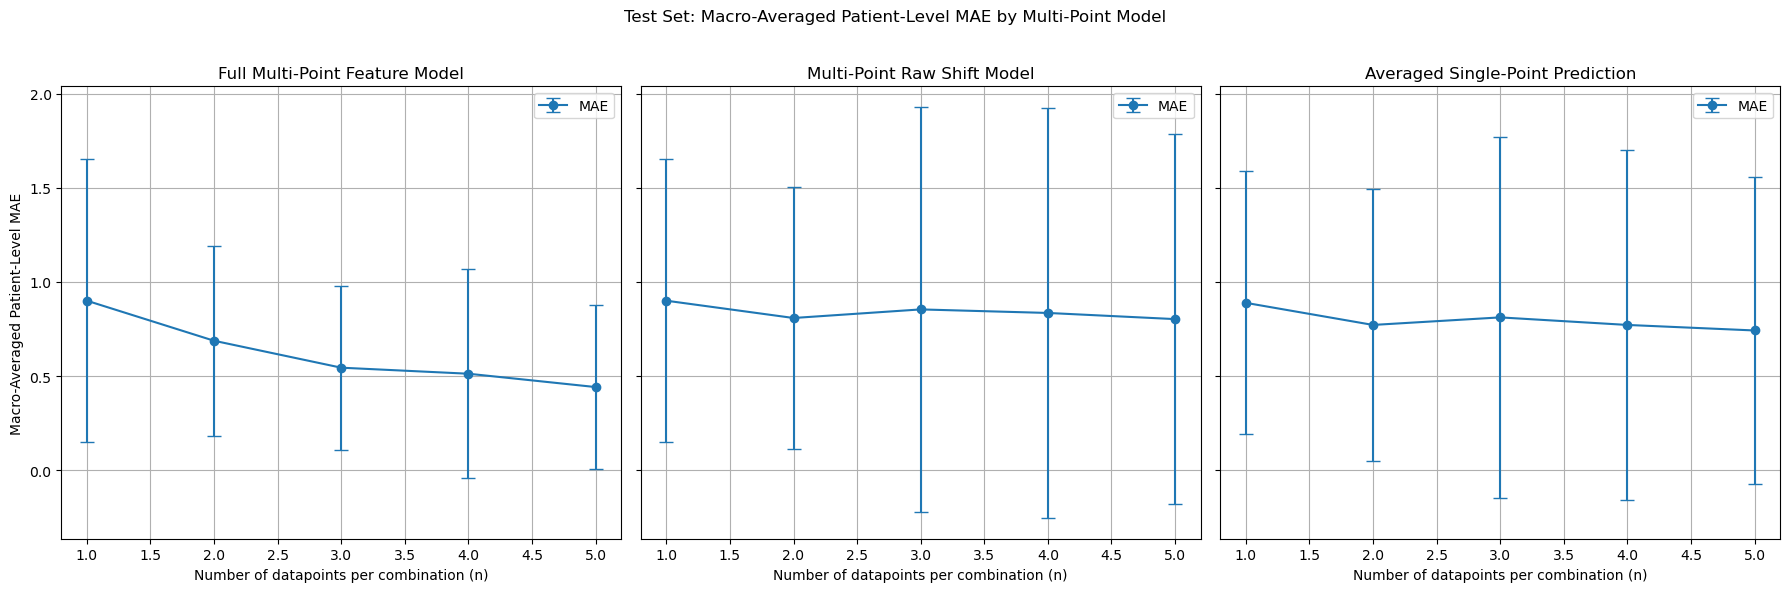

In [100]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
# results_full   = ...  # Full Multi-Point Feature Model
# results_raw    = ...  # Multi-Point Raw Shift Model
# results_single = ...  # Averaged Single-Point Prediction

# -- Make sure the DataFrames are sorted by n_points
results_full = results_full_df.sort_values('n_points')
results_raw = results_raw_df.sort_values('n_points')
results_single = results_single_df.sort_values('n_points')

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

models = [
    (results_full, "Full Multi-Point Feature Model"),
    (results_raw, "Multi-Point Raw Shift Model"),
    (results_single, "Averaged Single-Point Prediction")
]

for ax, (df, title) in zip(axes, models):
    ax.errorbar(df['n_points'], df['MAE'], yerr=df['MAE_std'], marker='o', capsize=5, label='MAE')
    ax.set_xlabel('Number of datapoints per combination (n)')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
axes[0].set_ylabel('Macro-Averaged Patient-Level MAE')
plt.suptitle('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# MAE by Model Type Plot

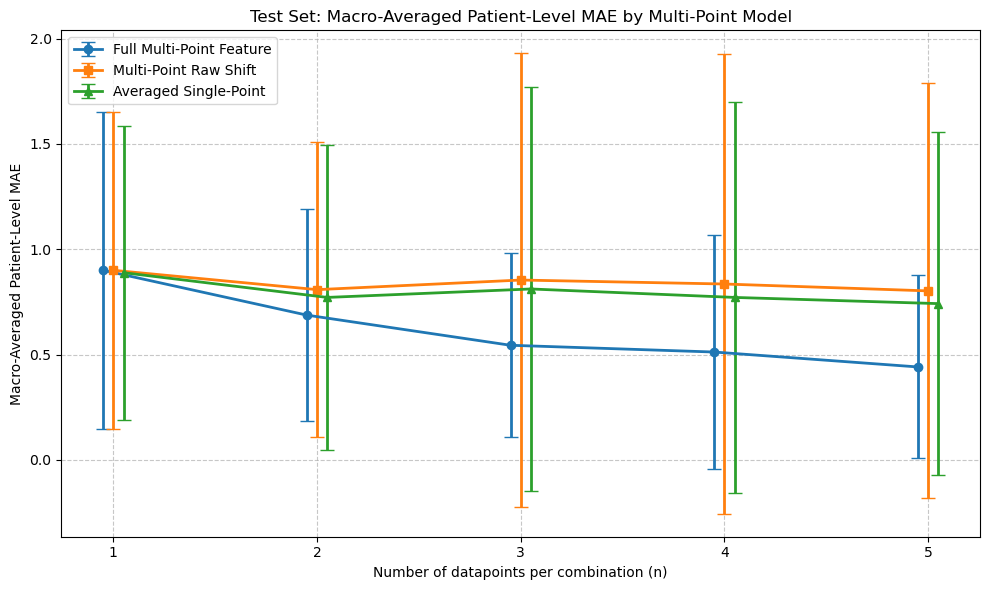

In [101]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
results_full = results_full_df.sort_values('n_points')
results_raw = results_raw_df.sort_values('n_points')
results_single = results_single_df.sort_values('n_points')

plt.figure(figsize=(10,6))

shift = 0.05
plt.errorbar(results_full['n_points'] - shift, results_full['MAE'], yerr=results_full['MAE_std'],
             marker='o', capsize=5, label='Full Multi-Point Feature', color='tab:blue', lw=2)
plt.errorbar(results_raw['n_points'], results_raw['MAE'], yerr=results_raw['MAE_std'],
             marker='s', capsize=5, label='Multi-Point Raw Shift', color='tab:orange', lw=2)
plt.errorbar(results_single['n_points'] + shift, results_single['MAE'], yerr=results_single['MAE_std'],
             marker='^', capsize=5, label='Averaged Single-Point', color='tab:green', lw=2)

plt.xlabel('Number of datapoints per combination (n)')
plt.ylabel('Macro-Averaged Patient-Level MAE')
plt.title('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()


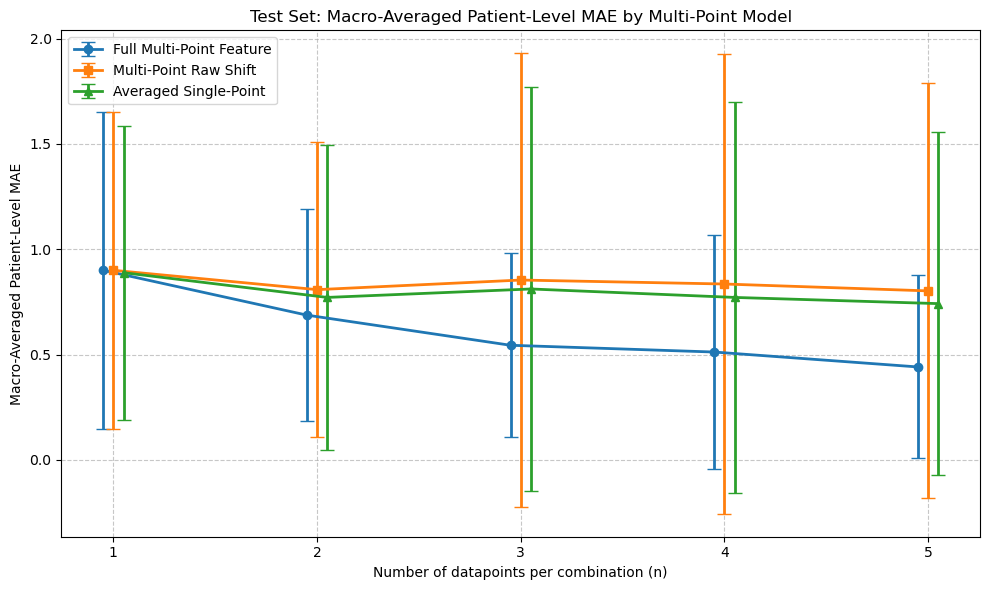

In [102]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
results_full = results_full.sort_values('n_points')
results_raw = results_raw.sort_values('n_points')
results_single = results_single.sort_values('n_points')

plt.figure(figsize=(10,6))

shift = 0.05
plt.errorbar(results_full['n_points'] - shift, results_full['MAE'], yerr=results_full['MAE_std'],
             marker='o', capsize=5, label='Full Multi-Point Feature', color='tab:blue', lw=2)
plt.errorbar(results_raw['n_points'], results_raw['MAE'], yerr=results_raw['MAE_std'],
             marker='s', capsize=5, label='Multi-Point Raw Shift', color='tab:orange', lw=2)
plt.errorbar(results_single['n_points'] + shift, results_single['MAE'], yerr=results_single['MAE_std'],
             marker='^', capsize=5, label='Averaged Single-Point', color='tab:green', lw=2)

plt.xlabel('Number of datapoints per combination (n)')
plt.ylabel('Macro-Averaged Patient-Level MAE')
plt.title('Test Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [103]:
results_full_val_df   = pd.DataFrame(results_full_val)
results_raw_val_df    = pd.DataFrame(results_raw_val)
results_single_val_df = pd.DataFrame(results_single_val)


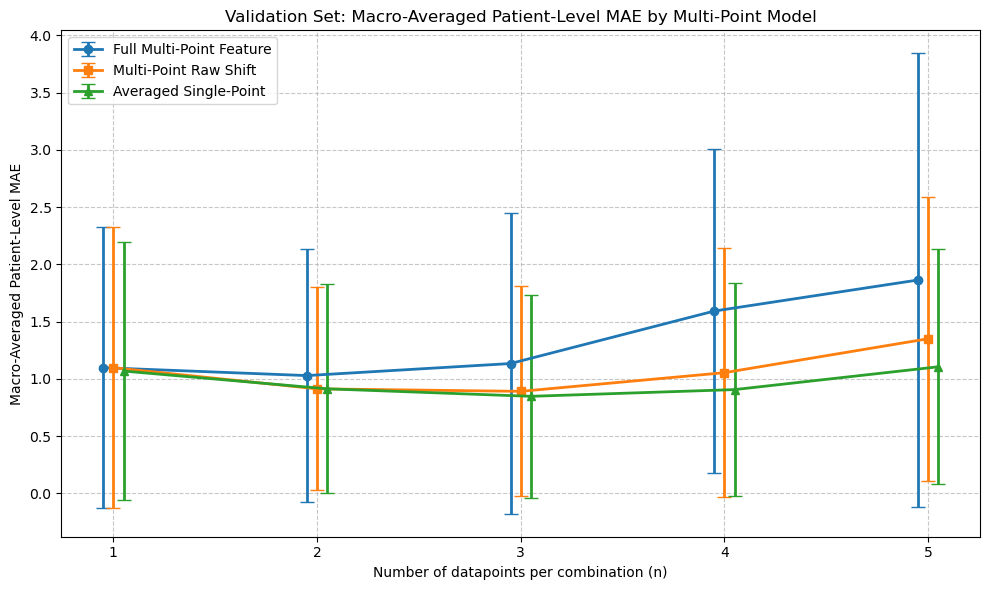

In [104]:
import matplotlib.pyplot as plt

# Example DataFrames (replace with your actual ones)
# Each df should have columns: 'n_points', 'MAE', 'MAE_std'
results_full_val = results_full_val_df.sort_values('n_points')
results_raw_val = results_raw_val_df.sort_values('n_points')
results_single_val = results_single_val_df.sort_values('n_points')

plt.figure(figsize=(10,6))

shift = 0.05
plt.errorbar(results_full_val['n_points'] - shift, results_full_val['MAE'], yerr=results_full_val['MAE_std'],
             marker='o', capsize=5, label='Full Multi-Point Feature', color='tab:blue', lw=2)
plt.errorbar(results_raw_val['n_points'], results_raw_val['MAE'], yerr=results_raw_val['MAE_std'],
             marker='s', capsize=5, label='Multi-Point Raw Shift', color='tab:orange', lw=2)
plt.errorbar(results_single_val['n_points'] + shift, results_single_val['MAE'], yerr=results_single_val['MAE_std'],
             marker='^', capsize=5, label='Averaged Single-Point', color='tab:green', lw=2)

plt.xlabel('Number of datapoints per combination (n)')
plt.ylabel('Macro-Averaged Patient-Level MAE')
plt.title('Validation Set: Macro-Averaged Patient-Level MAE by Multi-Point Model')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()


# For Thesis